## Contents
-  [1.Importing Libraries](#1)
-  [2.Dataset Management](#2)
    -  [2.1.Downloading and Extracting Dataset](#2.1)
    -  [2.2.Visualizing Dataset](#2.2)
    -  [2.3.Splitting Dataset](#2.3)
    -  [2.4.Pytorch DataLoaders](#2.4)
-  [3.Initializing pre-trained model](#3)
-  [4.Training](#4)
-  [5.Plotting Results](#5)
    -  [5.1.Plotting Loss vs MiniBatch](#5.1)
    -  [5.2.Plotting Accuracy vs MiniBatch](#5.2)
    -  [5.3.Plotting Loss vs Epoch](#5.3)
    -  [5.4.Plotting Accuracy vs Epoch](#5.4)
    -  [5.5.Plotting F1 Score vs Epoch](#5.5)
    -  [5.6.Plotting Recall vs Epoch](#5.6)
    -  [5.7.Plotting Precision vs Epoch](#5.7)
-  [6.Testing](#6)

### 1.Importing Libraries <a class="anchor" id="1"></a>

In [1]:
!pip install timm
import timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 kB 1.6 MB/s eta 0:00:00


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
from torch.utils.data import Dataset as Dataset
from torch.utils.data import DataLoader as DataLoader
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from PIL import Image
import os
import random

torch.cuda.empty_cache()
# random.seed(0)
# np.random.seed(0)
torch.manual_seed(0)

sns.set_style("darkgrid")
plt.rcParams["figure.figsize"] = (10,10)


### 2.Dataset Managament <a class="anchor" id="2"></a>

#### 1.Downloading and Extracting Dataset <a class="anchor" id="2.1"></a>

In [3]:
path = '/kaggle/input/surface-crack/'

#### 2.Visualizing Dataset <a class="anchor" id="2.2"></a>

#### 3.Splitting Dataset <a class="anchor" id="2.3"></a>

In [4]:
import os

image = {}
label = {}



for i in os.listdir(path):
    if i not in image:
        image[i] = []
        label[i] = []
    
    if i == "predict":
        for k in os.listdir(path+i):
            image[i].append(path+i+'/'+k)
            label[i].append(1 if j == "Positive" else 0)
        continue
        
    for j in os.listdir(path+i):
        for k in os.listdir(path+i+'/'+j):
            image[i].append(path+i+'/'+j+'/'+k)
            label[i].append(1 if j == "Positive" else 0)

#### 4.Pytorch DataLoaders <a class="anchor" id="2.4"></a>

In [5]:
from PIL import Image

class Dataset(Dataset):
    def __init__(self,x,y,transform = 'T.Resize((224,224))'):
        self.transform = transform
        self.x = x
        self.y = y 
        self.len = len(x)
   
    def __len__(self):
        return self.len
    
    def __getitem__(self,i):
        img = Image.open(self.x[i])
        return torch.FloatTensor(np.asarray(self.transform(img))),torch.LongTensor([self.y[i]])

batch_size = 16

transforms_train = T.Compose([
        T.Resize((224,224)),
#         T.RandomRotation(degrees=(-45, 45)),
#         T.RandomHorizontalFlip(),
#         T.RandomVerticalFlip(),
        T.ToTensor(),
#         T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

transforms_test = T.Compose([
        T.Resize((224,224)),
        T.ToTensor(),
#         T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

train_dataset = Dataset(image['train'],label['train'],transform =transforms_train)
validation_dataset = Dataset(image['valid'],label['valid'],transform =transforms_test)
test_dataset = Dataset(image['test'],label['test'],transform =transforms_test)

train_dataloader = DataLoader(train_dataset , batch_size = batch_size , shuffle = True )
validation_dataloader = DataLoader(validation_dataset , batch_size = batch_size , shuffle = True )
test_dataloader = DataLoader(test_dataset , batch_size = batch_size , shuffle = True )

In [6]:
next(iter(test_dataloader))

[tensor([[[[0.7529, 0.7373, 0.7333,  ..., 0.7569, 0.7608, 0.7608],
           [0.7373, 0.7333, 0.7412,  ..., 0.7529, 0.7608, 0.7608],
           [0.7216, 0.7333, 0.7529,  ..., 0.7529, 0.7569, 0.7569],
           ...,
           [0.7020, 0.7059, 0.7098,  ..., 0.7608, 0.7529, 0.7529],
           [0.7020, 0.7137, 0.7176,  ..., 0.7412, 0.7294, 0.7216],
           [0.6902, 0.7059, 0.7137,  ..., 0.7255, 0.7098, 0.6941]],
 
          [[0.7608, 0.7451, 0.7412,  ..., 0.7647, 0.7686, 0.7686],
           [0.7451, 0.7412, 0.7490,  ..., 0.7608, 0.7686, 0.7686],
           [0.7294, 0.7412, 0.7608,  ..., 0.7608, 0.7647, 0.7647],
           ...,
           [0.7059, 0.7098, 0.7137,  ..., 0.7608, 0.7529, 0.7529],
           [0.7059, 0.7176, 0.7216,  ..., 0.7412, 0.7294, 0.7216],
           [0.6941, 0.7098, 0.7176,  ..., 0.7255, 0.7098, 0.6941]],
 
          [[0.7490, 0.7333, 0.7294,  ..., 0.7608, 0.7647, 0.7647],
           [0.7333, 0.7294, 0.7373,  ..., 0.7569, 0.7647, 0.7647],
           [0.7176, 0.72

### 3.Initializing pre-trained model <a class="anchor" id="3"></a>

In [7]:
model_name = "vit_small_patch16_224"
class ViTBase16(nn.Module):
    def __init__(self, n_classes):

        super(ViTBase16, self).__init__()

        self.model = timm.create_model(model_name, pretrained=True)
        

        self.model.head = nn.Linear(self.model.head.in_features, n_classes)

    def forward(self, x):
        x = self.model(x)
        return x


model = ViTBase16(2)
for param in model.parameters():
    param.requires_grad = True

### 4.Training <a class="anchor" id="4"></a>

In [8]:
lr = 0.001
epoch = 30
train_dataset_size = train_dataset.__len__()
validation_dataset_size = validation_dataset.__len__()
train_n_minibatches = train_dataloader.__len__()
validation_n_minibatches = validation_dataloader.__len__()

device = 'cuda'
model.to(device)
loss_history = [[],[]] #[[train], [validation]]
accuracy_history = [[],[]] #[[train], [validation]]
# prec_history = [[],[]] #[[train], [validation]]
# recall_history = [[],[]] #[[train], [validation]]
# f1_history = [[],[]] #[[train], [validation]]
# support_history = [[],[]] #[[train], [validation]]

results = [[],[]]

criterion = nn.CrossEntropyLoss()  
optimizer = torch.optim.SGD(model.parameters(),lr = lr)



In [9]:
from sklearn.metrics import precision_recall_fscore_support

best_val_acc = 0

for e in range(epoch):
    print(f'---------------------------------------EPOCH {e+1}-------------------------------------------')
    y_all_train_true = []
    y_all_train_pred = []
    y_all_val_true = []
    y_all_val_pred = []
    
    for batch_idx , (x ,y) in enumerate(train_dataloader):
        model.train() # Setting mode to train
        optimizer.zero_grad()
        x , y = x.to(device) , y.to(device)
        y_pred = model(x).to(device)
        
        y_all_train_true+=y.cpu().detach().view(-1,).tolist()
        y_all_train_pred+=torch.argmax(y_pred, dim=1).detach().tolist()
        
        # Calculating Loss
        loss = criterion(y_pred,y.reshape(x.shape[0]))
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 3)
        optimizer.step()
        loss_history[0].append(float(loss.detach()))
        
        #Calaculating Accuracy
        correct = 0
        y_pred = y_pred.cpu().detach().numpy().tolist()
        y = y.cpu().detach().numpy().tolist()
        for i in range(x.shape[0]):
            n = 0
            n = y_pred[i].index(max(y_pred[i]))
            if n == y[i][0]:
                correct = correct + 1
        accuracy_history[0].append((correct/x.shape[0])*100)
        
        if batch_idx % (len(train_dataloader)//2) == 0:
            # Printing Log
            print(f'LOSS for EPOCH {e+1} BATCH {batch_idx}/{train_n_minibatches} TRAIN LOSS : {loss_history[0][-1]}',end = ' ')
            print(f'TRAIN ACCURACY : {accuracy_history[0][-1]}',end = ' ')
            with torch.no_grad():
                # Calculating loss and accuracy for validation
                model.eval()
                for _batch_idx_ , (x ,y) in enumerate(validation_dataloader):
                    x , y = x.to(device) , y.to(device)
                    y_pred = model(x).to(device)
                    
                    y_all_val_true+=y.cpu().detach().view(-1,).tolist()
                    y_all_val_pred+=torch.argmax(y_pred, dim=1).detach().tolist()
                    
                    validation_loss = criterion(y_pred,y.reshape(x.shape[0]))
                    loss_history[1].append(float(validation_loss.detach()))
                    
                    correct = 0
                    y_pred = y_pred.cpu().detach().numpy().tolist()
                    y = y.cpu().detach().numpy().tolist()      
                    for i in range(x.shape[0]):
                        n = 0
                        n = y_pred[i].index(max(y_pred[i]))
                        if n == y[i][0]:
                            correct = correct + 1
                    accuracy_history[1].append((correct/x.shape[0])*100)
                        
                    
                print(f'VALIDATION LOSS : {sum(loss_history[1][-1:-validation_n_minibatches-1:-1])/validation_n_minibatches}',end = ' ')
                print(f'VALIDATION ACCURACY : {sum(accuracy_history[1][-1:-validation_n_minibatches-1:-1])/validation_n_minibatches}')
    
    # Saving the model progress
    torch.save(model.state_dict(),model_name)
    
    results[0].append(precision_recall_fscore_support(y_all_train_true,y_all_train_pred))
    results[1].append(precision_recall_fscore_support(y_all_val_true,y_all_val_pred))
    
    x = sum(accuracy_history[1][-1:-1*validation_n_minibatches-1:-1])/validation_n_minibatches
    if x>best_val_acc:
        best_val_acc = x
        torch.save(model.state_dict(),'vit_best')
    #Log for e+1th epoch
    print(f'--------------------------------------------------------------------------------------------')
    print(f'Loss for EPOCH {e+1}  TRAIN LOSS : {sum(loss_history[0][-1:-train_n_minibatches-1:-1])/train_n_minibatches}',end = ' ')
    print(f'TRAIN PREC : {results[0][-1][0]} RECALL : {results[0][-1][1]} F1 : {results[0][-1][2]}',end=" ")
    print(f'ACC : {sum(accuracy_history[0][-1:-train_n_minibatches-1:-1])/train_n_minibatches}')
    print(f'VALIDATION LOSS for EPOCH {e+1} : {sum(loss_history[1][-1:-1*validation_n_minibatches-1:-1])/validation_n_minibatches}',end = ' ')
    print(f'VALIDATION PREC : {results[1][-1][0]} RECALL : {results[1][-1][1]} F1 : {results[1][-1][2]}',end=" ")
    print(f' ACC : {sum(accuracy_history[1][-1:-1*validation_n_minibatches-1:-1])/validation_n_minibatches}')

    # if int(sum(accuracy_history[1][-1:-1*validation_n_minibatches-1:-1])/validation_n_minibatches) == 100:
    #     break
    print('---------------------------------------------------------------------------------------------')

---------------------------------------EPOCH 1-------------------------------------------
LOSS for EPOCH 1 BATCH 0/38 TRAIN LOSS : 2.03619647026062 TRAIN ACCURACY : 31.25 VALIDATION LOSS : 1.2640707813776457 VALIDATION ACCURACY : 52.40384615384615
LOSS for EPOCH 1 BATCH 19/38 TRAIN LOSS : 0.5546549558639526 TRAIN ACCURACY : 75.0 VALIDATION LOSS : 0.531353453030953 VALIDATION ACCURACY : 69.71153846153847
--------------------------------------------------------------------------------------------
Loss for EPOCH 1  TRAIN LOSS : 0.669717362052516 TRAIN PREC : [0.65311005 0.85164835] RECALL : [0.91       0.51666667] F1 : [0.76044568 0.64315353] ACC : 71.71052631578948
VALIDATION LOSS for EPOCH 1 : 0.531353453030953 VALIDATION PREC : [0.57706093 0.67768595] RECALL : [0.805 0.41 ] F1 : [0.67223382 0.51090343]  ACC : 69.71153846153847
---------------------------------------------------------------------------------------------
---------------------------------------EPOCH 2---------------------

### 5.Plotting results <a class="anchor" id="4"></a>

#### 1.Plotting Loss vs MiniBatch<a class="anchor" id="5.1"></a>

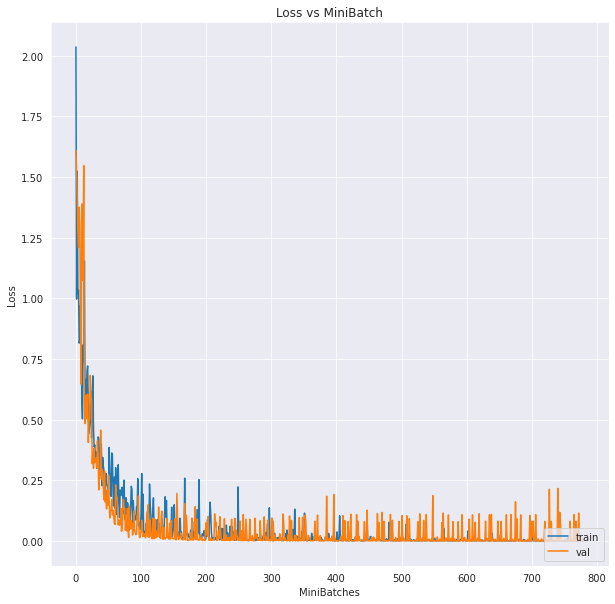

In [10]:
sns.lineplot(x=range(len(loss_history[1])),y=loss_history[0][::len(loss_history[0])//len(loss_history[1])][:len(loss_history[1])])
sns.lineplot(x=range(len(loss_history[1])),y=loss_history[1])

plt.legend(loc='lower right', labels=['train', 'val'])
plt.title("Loss vs MiniBatch")
plt.xlabel('MiniBatches')
plt.ylabel('Loss')


plt.show()


#### 2.Plotting Accuracy vs MiniBatch<a class="anchor" id="5.2"></a>

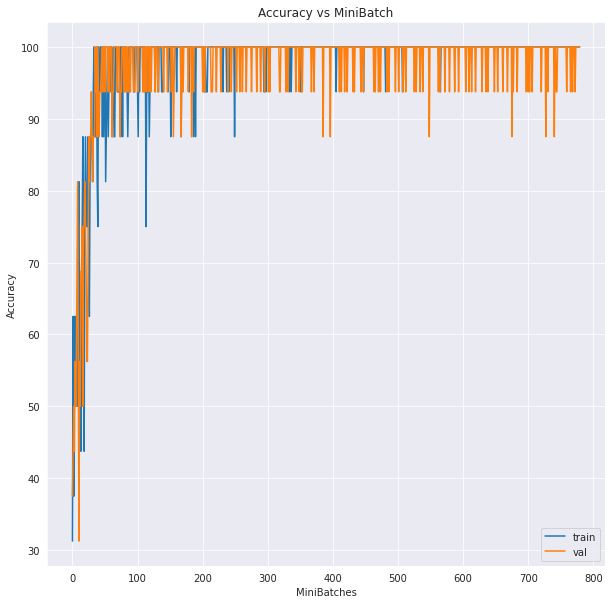

In [11]:
sns.lineplot(x=range(len(accuracy_history[1])),y=accuracy_history[0][::len(accuracy_history[0])//len(accuracy_history[1])][:len(accuracy_history[1])])
sns.lineplot(x=range(len(accuracy_history[1])),y=accuracy_history[1])

plt.legend(loc='lower right', labels=['train', 'val'])
plt.title("Accuracy vs MiniBatch")
plt.xlabel('MiniBatches')
plt.ylabel('Accuracy')

plt.show()


#### 3.Plotting Loss vs Epoch<a class="anchor" id="5.3"></a>

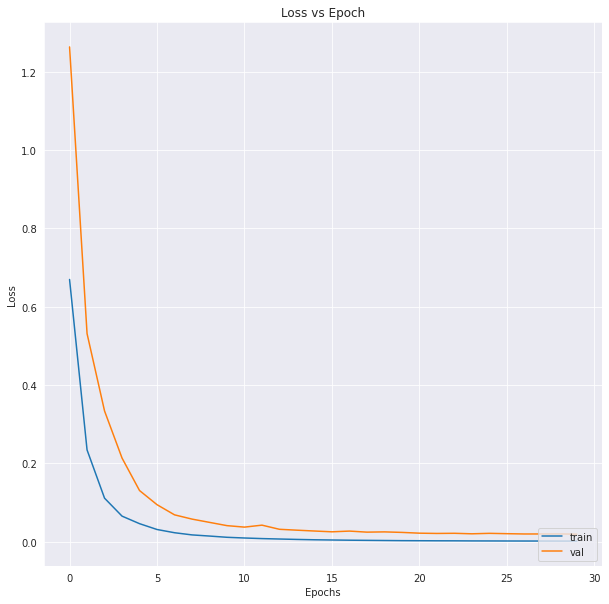

In [12]:
# Plotting Loss per epoch
loss_per_epoch = [[],[]]
for i in range(epoch):
    temp = 0
    for j in loss_history[0][i*train_n_minibatches:(i+1)*train_n_minibatches]:
        temp = temp + j
    loss_per_epoch[0].append(temp/train_n_minibatches)
    temp = 0
    for j in loss_history[1][i*validation_n_minibatches:(i+1)*validation_n_minibatches]:
        temp = temp + j
    loss_per_epoch[1].append(temp/validation_n_minibatches)    

sns.lineplot(x=range(len(loss_per_epoch[0])),y=loss_per_epoch[0])
sns.lineplot(x=range(len(loss_per_epoch[1])),y=loss_per_epoch[1])

plt.legend(loc='lower right', labels=['train', 'val'])
plt.title("Loss vs Epoch")
plt.xlabel('Epochs')
plt.ylabel('Loss')


plt.show()

#### 4.Plotting Accuracy vs Epoch<a class="anchor" id="5.4"></a>

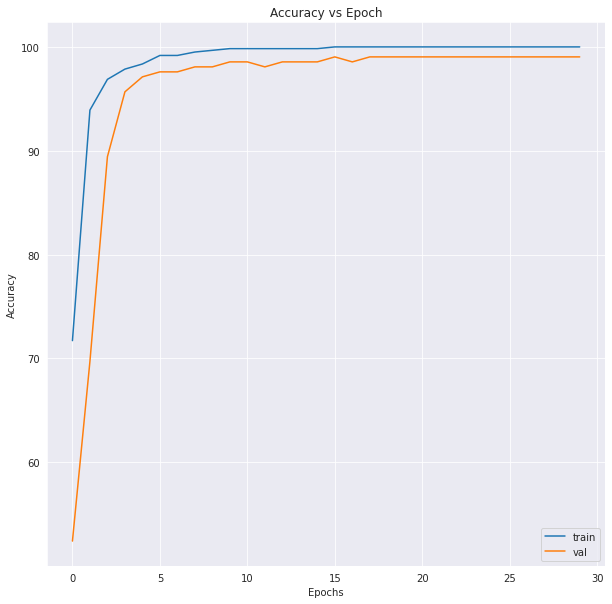

In [13]:
# Plotting Accuracy per epoch
accuracy_per_epoch = [[],[]]
for i in range(epoch):
    temp = 0
    for j in accuracy_history[0][i*train_n_minibatches:(i+1)*train_n_minibatches]:
        temp = temp + j
    accuracy_per_epoch[0].append(temp/train_n_minibatches)
    temp = 0
    for j in accuracy_history[1][i*validation_n_minibatches:(i+1)*validation_n_minibatches]:
        temp = temp + j
    accuracy_per_epoch[1].append(temp/validation_n_minibatches)    

sns.lineplot(x=range(len(accuracy_per_epoch[0])),y=accuracy_per_epoch[0])
sns.lineplot(x=range(len(accuracy_per_epoch[1])),y=accuracy_per_epoch[1])

plt.legend(loc='lower right', labels=['train', 'val'])
plt.title("Accuracy vs Epoch")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.show()

#### 5.Plotting F1Score vs Epoch<a class="anchor" id="5.4"></a>

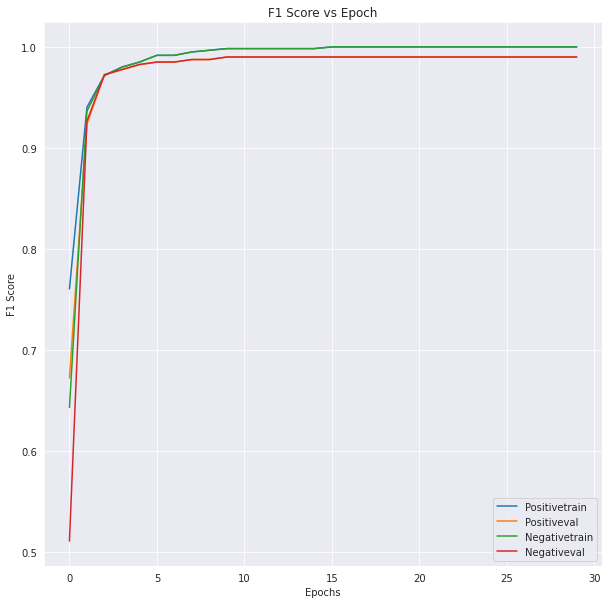

In [14]:
labels = {0:'Positive',
1:'Negative'}

legend = []



for j in range(2):
    sns.lineplot(x=range(len(results[0])),y=[results[0][i][2][j] for i in range(len(results[0]))])
    sns.lineplot(x=range(len(results[1])),y=[results[1][i][2][j] for i in range(len(results[1]))])
    legend+=[labels[j]+'train', labels[j]+'val']



plt.legend(loc='lower right', labels=legend)
plt.title("F1 Score vs Epoch")
plt.xlabel('Epochs')
plt.ylabel('F1 Score')


plt.show()

#### 6.Plotting Recall vs Epoch<a class="anchor" id="5.4"></a>

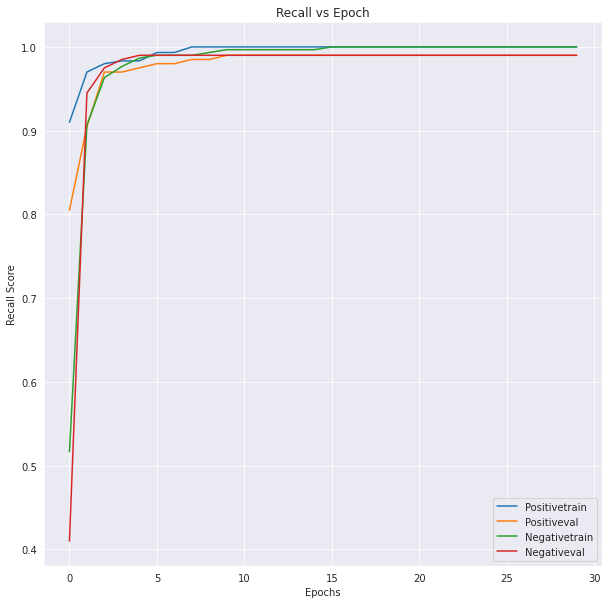

In [15]:
for j in range(2):
    sns.lineplot(x=range(len(results[0])),y=[results[0][i][1][j] for i in range(len(results[0]))])
    sns.lineplot(x=range(len(results[1])),y=[results[1][i][1][j] for i in range(len(results[1]))])


plt.legend(loc='lower right', labels=legend)
plt.title("Recall vs Epoch")
plt.xlabel('Epochs')
plt.ylabel('Recall Score')


plt.show()

#### 6.Plotting Precision vs Epoch<a class="anchor" id="5.4"></a>

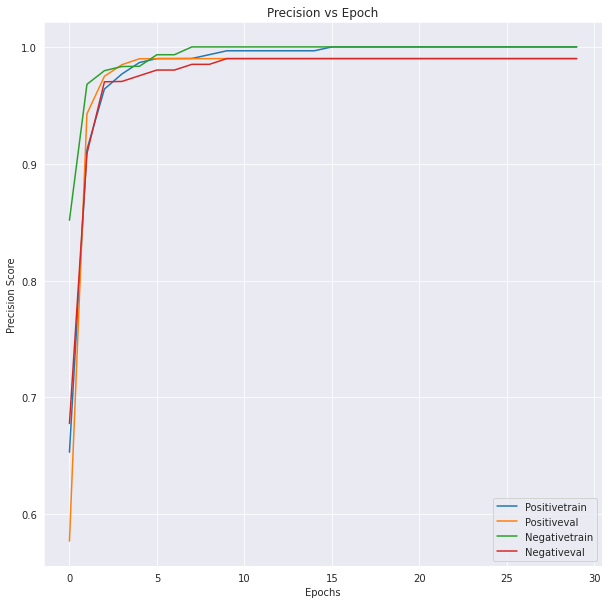

In [16]:
for j in range(2):
    sns.lineplot(x=range(len(results[0])),y=[results[0][i][0][j] for i in range(len(results[0]))])
    sns.lineplot(x=range(len(results[1])),y=[results[1][i][0][j] for i in range(len(results[1]))])


plt.legend(loc='lower right', labels=legend)
plt.title("Precision vs Epoch")
plt.xlabel('Epochs')
plt.ylabel('Precision Score')


plt.show()

### 6.Testing <a class="anchor" id="6"></a>

In [17]:
y_all_true = []
y_all_pred = []
test_loss_history = []
test_accuracy_history = []


model.eval()
for _batch_idx_ , (x ,y) in enumerate(test_dataloader):
    x , y = x.to(device) , y.to(device)
    y_pred = model(x)
    test_loss = criterion(y_pred,y.reshape(x.shape[0]))
    test_loss_history.append(float(test_loss.detach()))
    correct = 0
    y_all_true+=y.cpu().detach().view(-1,).tolist()
    y_all_pred+=torch.argmax(y_pred, dim=1).detach().tolist()
    y_pred = y_pred.cpu().detach().numpy().tolist()
    y = y.cpu().detach().numpy().tolist()      
    for i in range(x.shape[0]):
        n = 0
        n = y_pred[i].index(max(y_pred[i]))
        if n == y[i][0]:
            correct = correct + 1
    test_accuracy_history.append((correct/len(y))*100)
    

                        
print(f'LOSS : {sum(test_loss_history)/len(test_loss_history)}  ACCURACY : {sum(test_accuracy_history)/len(test_accuracy_history)}')                    

result = precision_recall_fscore_support(y_all_true,y_all_pred)

print(f"TEST PREC: {result[0]} RECALL: {result[1]} F1 SCORE: {result[2]} SUPPORT: {result[3]}")


LOSS : 0.017205384703209765  ACCURACY : 100.0
TEST PREC: [1. 1.] RECALL: [1. 1.] F1 SCORE: [1. 1.] SUPPORT: [100 100]


In [18]:
class TestDataset(Dataset):
    def __init__(self,x,transform = 'T.Resize((224,224))'):
        self.transform = transform
        self.x = x
        self.len = len(x)
   
    def __len__(self):
        return self.len
    
    def __getitem__(self,i):
        img = Image.open(self.x[i]).convert('RGB')
        return torch.FloatTensor(np.asarray(self.transform(img)))
    

test_img = [path+"predict/"+i for i in os.listdir(path+"predict/")]
test_dataset = TestDataset(test_img,transform =transforms_test)
test_dataloader = DataLoader(test_dataset , batch_size = batch_size , shuffle = False )

predictions = []
with torch.no_grad():
    model.eval()
    for _batch_idx_ , x in enumerate(test_dataloader):
        x = x.to(device)
        y_pred = model(x).to(device)
        pred = torch.argmax(y_pred, dim=1)+1
        predictions+=pred.cpu().tolist()

df = pd.DataFrame(list(zip([test_img[i].split('/')[-1] for i in range(len(test_img))], predictions)), index =None, columns =['image', 'category'])
df.to_csv("submission.csv", index=False)
df

,image,category
0,IMG_1133.JPG,1
1,IMG_1129.JPG,1
2,IMG_1132.JPG,2
3,IMG_1130.JPG,2
4,IMG_1134.JPG,1
5,IMG_1131.JPG,1
